In [92]:
%%capture
!uv pip install s3fs zarr ctime fsspec rioxarray

*Workshop 4. Doing research with hydrological data*


# Practical 1: Compare rainfall estimates from different sources


## Learning objectives:
- Format rainfall data from different sources
- To determine the uncertainties in rainfall estimates between gridded rainfall and rain gauge data
- 


# Introduction
Rainfall is notoriously difficult to measure accurately, but in the UK we have a dense network of both [rain gauges](https://en.wikipedia.org/wiki/Rain_gauge) and [rain radar](https://en.wikipedia.org/wiki/Weather_radar) stations (**Figure 1**). These network gives us a relatively reliable and consistent estimate of rainfall through time, even when there is missing or wrong data, because estimates are cross-checked agaisnt other nearby measurements. 

![Map of UK rain gauge stations](../content/Maps-of-daily-rain-gauges-used-to-derive-the-CEH-GEAR-data-set-a-monthly-rain-gauges.png)  
*Figure 1. Maps of daily rain gauges in 2012: (a) monthly rain gauges and (b) daily rain gauges (source: Keller et al. 2015).*


The UKCEH is also working-on a updated interactive map of the UK's rain gauge network (as of 2025), which you can find a version of [here](https://thomasjkeel.github.io/UK-Rain-Gauge-Network/gauges.html).

## Gridded rainfall data
> *Gridded rainfall products provide a spatially- and temporally-uniform estimate of rainfall*

Whilst, the UK's rain gauge network provides valuable data, its coverage is both spatially and temporally uneven. Some areas—such as Scotland—have a much denser concentration of gauges than others, like the South of England. Additionally, the gauges themselves vary in age and data quality.  

As such, it can be inconvenient to work with rain gauge data. For this reason, environmental researchers often prefer datasets that are interpolated onto regular grids, which are easier to process, analyze, and compare over space and time.


For the UK, two main gridded rainfall products exist:  
1. CEH-GEAR — provides daily/monthly 1km gridded rainfall, produced by the UKCEH and described in [Keller et al. 2015](https://essd.copernicus.org/articles/7/143/2015/)
2. HadUK-Grid — provides daily/monthly/seasonal/annual 1km gridded rainfall, produced by the Met Office and described in [Hollis et al. 2019](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/gdj3.78)

Each product provides slightly different methodology for spatially interpolating data from the UK rain gauge network to a regular 1km grid, shown diagramatically in Figure 2 (see more in those papers if you are interested in the specifics). For this practical, we will be using the CEH-GEAR dataset, but for future, you can access the HadUK-Grid [here](https://catalogue.ceda.ac.uk/uuid/4dc8450d889a491ebb20e724debe2dfb/)).


![example of gridding](../content/gridding_example_from_gdal.png)  
*Figure 2. Diagram showing example of interpolation of points to regular grid (source: GDAL 2025).*





In [2]:
# Load required libraries
import fsspec
import zarr

import geopandas as gpd
import polars as pl
import xarray as xr

import rainfallqc
import rioxarray

import matplotlib.pyplot as plt

# practical-specific file:
import data_utils

In [3]:
# Global variables for coordinates of Severn River catchment
SEVERN_NORTHING_RANGE = [270000, 350000]
SEVERN_EASTING_RANGE = [280000, 390000]

# 1. Load rainfall data
First we will read in gridded rainfall and rain gauge data using code shown in Workshop 2.

**External data sources:**
- UK-wide CEH-GEAR rainfall data - from the JASMIN object-store
- Rain gauge data for the Severn River Catchment - from the JASMIN object-store
- Severn catchment boundaries - from the National River Flow Archive ([NRFA](https://nrfa.ceh.ac.uk/data/search))
- River Severn watercourse - from [OS Open Rivers](https://www.ordnancesurvey.co.uk/products/os-open-rivers)

## 1.1 Load CEH-GEAR (gridded rainfall data)
Using the code from Workshop 2, below we connect to the S3 bucket on the JASMIN object-store (remote) and load in a local version of the daily CEH-GEAR file ("geardaily_fulloutput_yearly_100km_chunks.zarr")

In [95]:
fdri_fs = fsspec.filesystem("s3", asynchronous=True, anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")
gear_daily_zstore = zarr.storage.FsspecStore(fdri_fs, path="geardaily/GB/geardaily_fulloutput_yearly_100km_chunks.zarr")
gear_daily = xr.open_zarr(gear_daily_zstore, decode_times=True, decode_cf=True)
gear_daily = gear_daily.sortby('y') # flip y coordinates
gear_daily # 310 GB worth of data

<xarray.Dataset> Size: 666GB
Dimensions:          (y: 1251, x: 701, time: 47481)
Coordinates:
    crs              int16 2B ...
    lat              (y, x) float64 7MB dask.array<chunksize=(96, 100), meta=np.ndarray>
    lon              (y, x) float64 7MB dask.array<chunksize=(96, 100), meta=np.ndarray>
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 6kB 0.0 1e+03 2e+03 ... 6.98e+05 6.99e+05 7e+05
  * y                (y) float64 10kB 0.0 1e+03 2e+03 ... 1.249e+06 1.25e+06
Data variables:
    min_dist         (time, y, x) float64 333GB dask.array<chunksize=(365, 96, 100), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 333GB dask.array<chunksize=(365, 96, 100), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In these practicals, there will be questions, please fill them in the best you can before moving on (or ask us for help)
#### 🤨 Question: what type of file is the input data?
Replace the ??? in this markdown box with your answer 
(*hint: check the file extension*)

**Answer:** ???

#### 🤨 Question: what data type is the 'gear_daily' data we have loaded in?

Replace the ??? in the code-block below with your answer

In [42]:
type(???)

SyntaxError: invalid syntax (3631905147.py, line 1)

Let's have a quick look at one day in the CEH-GEAR dataset...

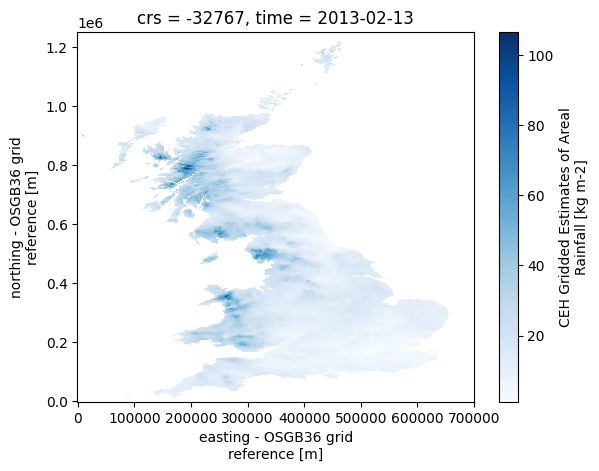

In [96]:
# plot data
fig, ax = plt.subplots(1)
gear_daily.sel(time="2013-02-13")['rainfall_amount'].plot(ax=ax, cmap='Blues')


## 1.2 Load daily rain gauge data
Next, we will load daily rain gauge data and it's associated metadata from the JASMIN object-store.

🐻‍❄️ **Note:** we use the [polars](https://pola.rs/) instead of pandas to load data, but its syntax should be relatively familiar.

In [6]:
severn_rain_gauge_data = pl.read_csv('s3://rain-gauge/hourly_severn_rain_gauge_data.csv', storage_options={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk", 'anon': True}, try_parse_dates=True)
severn_rain_gauge_metadata = pl.read_csv('s3://rain-gauge/hourly_severn_rain_gauge_metadata.csv', storage_options={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk", 'anon': True})

In [56]:
severn_rain_gauge_data.head()

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
89714,1978-10-01 00:00:00,0.0
89714,1978-10-02 00:00:00,2.0
89714,1978-10-03 00:00:00,0.0
89714,1978-10-04 00:00:00,0.0
89714,1978-10-05 00:00:00,0.0
…,…,…
429880,1965-10-19 00:00:00,0.0
429880,1965-10-20 00:00:00,0.0
429880,1965-10-21 00:00:00,0.0


In [8]:
severn_rain_gauge_metadata.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
89714,2913,"""STRONGFORD W WKS""","""GB-GBN""",387932,339157,28,95,"""/BI/UK/GB/ENG/STS/"""
90358,2918,"""SUGNALL HALL""","""GB-GBN""",379831,331185,28,143,"""/BI/UK/GB/ENG/STS/"""
90359,2919,"""ECCLESHALL, SUGNALL HALL""","""GB-GBN""",379800,331200,28,137,"""/BI/UK/GB/ENG/STS/"""
90492,2920,"""WALTON HALL GARDENS""","""GB-GBN""",384900,328500,28,99,"""/BI/UK/GB/ENG/STS/"""
90537,2921,"""WHITMORE P STA""","""GB-GBN""",379900,340100,28,121,"""/BI/UK/GB/ENG/CHS/"""


#### 🤨 Question: what type of file is the input data?

Replace the ??? in this markdown box with your answer

**Answer:** ???

#### 🤨 Question: what data type is the 'severn_rain_gauge_data'?

Replace the ??? in the code-block below with your answer

In [ ]:
???

Let's subset the data to look at precipitation from a single rain gauge...

In [8]:
severn_rain_gauge_data.filter(pl.col("ID") == 90537)

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
90537,1961-01-01 00:00:00,2.0
90537,1961-01-02 00:00:00,5.1
90537,1961-01-03 00:00:00,1.5
90537,1961-01-04 00:00:00,0.0
90537,1961-01-05 00:00:00,10.9
…,…,…
90537,1989-03-27 00:00:00,7.3
90537,1989-03-28 00:00:00,0.1
90537,1989-03-29 00:00:00,0.0


🐼: above code is equivalent to: `severn_rain_gauge_data.loc[severn_rain_gauge_data["ID"] == 90537]`

#### 🤨 Task: Subset the precipitation data to the station: "WALFORD" 

Replace the ??? below with your answer

*Hint: you can use the `.filter` method like above*

In [46]:
# Step 1. Find the "ID" for the station with the name: "WALFORD" in the metadata
severn_rain_gauge_metadata.???

In [ ]:
# Step 2. Using that ID, subset the rain gauge data
severn_rain_gauge_data.???

## 1.3 Load spatial datasets for Upper Severn catchment
Finally, we download some spatial data for the River Severn, including catchment boundaries from the NRFA, and watercourse data from Ordinance Survey.

Data originally downloaded from: [NRFA](https://nrfa.ceh.ac.uk/data/search) & [Ordinance Survey](https://www.ordnancesurvey.co.uk/products/os-open-rivers)

This bash script below will fetch and download spatial data from GitHub and store it locally in the folder 'severn_catchment_data'

In [9]:
%%capture
# !wget -O https://github.com/Thomasjkeel/UKCEH_Summer_School_2025/blob/edit/workshop-3/Workshop_4/severn_catchment_data.tar.gz
!mkdir -p severn_catchment_data 
!tar -xvf severn_catchment_data.tar.gz -C severn_catchment_data

Load shapefiles & geojson using geopandas

In [10]:
# Greater Severn catchment boundary
bewdley_shp = gpd.read_file('severn_catchment_data/Bewdley/54001/54001.shp')

# Upper Severn catchment boundaries
abermule_shp = gpd.read_file('severn_catchment_data/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('severn_catchment_data/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('severn_catchment_data/Plynlimon Flume/54022/54022.shp')

In [11]:
# Load rivers linestrings
severn_catchment_river_linestrings = gpd.read_file('severn_catchment_data/rivers_around_severn.geojson')
severn_river_linestrings = severn_catchment_river_linestrings.loc[severn_catchment_river_linestrings['name1'].str.contains('River Severn')]

Next, we plot the catchment boundaries and the River Severn

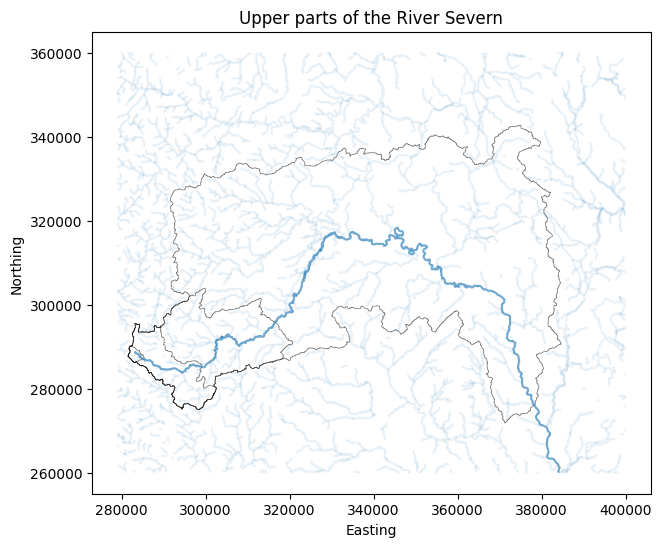

In [12]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
abermule_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)

severn_catchment_river_linestrings.plot(ax=ax, alpha=.1)
severn_river_linestrings.plot(ax=ax, alpha=.6)
ax.set_title("Upper parts of the River Severn")
plt.subplots_adjust(hspace=.2)

We'll also load in some height data 

In [13]:
severn_hght = rioxarray.open_rasterio('severn_catchment_data/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)
severn_hght = severn_hght / 10 # divide by 10, so in metres
severn_hght = severn_hght.sel(x=slice(*SEVERN_EASTING_RANGE), y=slice(*SEVERN_NORTHING_RANGE))

Text(0.5, 1.0, 'Height profile of upper parts of the River Severn')

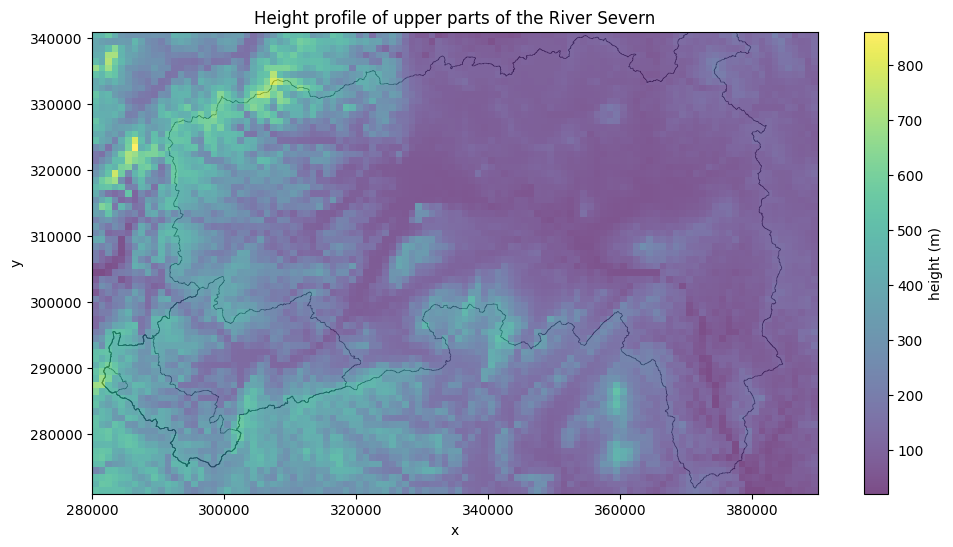

In [14]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)
ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
abermule_shp.plot(ax=ax, facecolor='none', alpha=.8, linewidth=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.8, linewidth=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.8, linewidth=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.8, linewidth=.5)
severn_hght.plot(ax=ax, alpha=.7, cbar_kwargs={"label": "height (m)"})

ax.set_title("Height profile of upper parts of the River Severn")


# 2. Format the data
Most of data science is about data cleaning and formatting. This is especially true for those using environmental data, where we often have datasets from many different sources, and that are of varying quality.

>*Note:* the rain gauge data we are using is not explicitly quality controlled, but see [RainfallQC](https://github.com/NERC-CEH/RainfallQC) for a Python package that can do this (and some [examples](https://github.com/Thomasjkeel/RainfallQC-notebooks))

In this next section, we will prepare the rain gauge dataset for comparison to gridded rainfall

## 2.1 Checking for data completeness
There are many issues with this rainfall dataset including gaps, streaks, exceedances of world records, mis-inputted data. To quickly format the data, we will focus only on finding gaps. We will call this measure 'completeness' and will calculate this for each gauge.


In [156]:
# load in a single gappy gauge
one_gauge = severn_rain_gauge_data.filter(pl.col("ID") == 427166 )# 428554

<Axes: xlabel='DATETIME'>

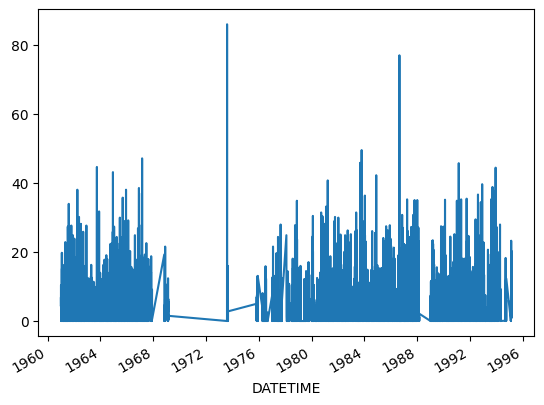

In [157]:
# below we convert polars to pandas to let us plot longer time series
one_gauge.to_pandas().set_index("DATETIME")['PRECIPITATION'].plot()

In the above plot, clearly there are some gaps in the data. We do not want to include this in our final clean dataset.  

Let's create a completeness metric, by comparing the start and end dates of each gauge, and then checking how many data rows are missing

In [162]:
severn_rain_gauge_data_observed = severn_rain_gauge_data.group_by("ID").agg([
        pl.col("DATETIME").min().alias("start_date"),
        pl.col("DATETIME").max().alias("end_date"),
        pl.len().alias("observed_days"),
    ])
severn_rain_gauge_data_observed.head()

ID,start_date,end_date,observed_days
i64,datetime[μs],datetime[μs],u32
428936,1946-04-01 00:00:00,1957-12-31 00:00:00,4293
429474,1961-01-01 00:00:00,1961-12-31 00:00:00,365
428808,1971-05-01 00:00:00,1977-08-31 00:00:00,1674
423144,2006-09-01 00:00:00,2024-12-31 00:00:00,6575
424217,2006-01-01 00:00:00,2024-12-31 00:00:00,6696


In [163]:
severn_rain_gauge_data_observed_and_expected = severn_rain_gauge_data_observed.with_columns([
        ((pl.col("end_date") - pl.col("start_date")).dt.total_days() + 1).alias("expected_days"),
    ])

severn_rain_gauge_data_observed_and_expected.head()

ID,start_date,end_date,observed_days,expected_days
i64,datetime[μs],datetime[μs],u32,i64
428936,1946-04-01 00:00:00,1957-12-31 00:00:00,4293,4293
429474,1961-01-01 00:00:00,1961-12-31 00:00:00,365,365
428808,1971-05-01 00:00:00,1977-08-31 00:00:00,1674,2315
423144,2006-09-01 00:00:00,2024-12-31 00:00:00,6575,6697
424217,2006-01-01 00:00:00,2024-12-31 00:00:00,6696,6940


In [164]:
severn_rain_gauge_data_completeness = severn_rain_gauge_data_observed_and_expected.with_columns([
        ((pl.col("observed_days") / pl.col("expected_days")) * 100).alias("perc_completeness")
    ])

severn_rain_gauge_data_completeness.head()

ID,start_date,end_date,observed_days,expected_days,perc_completeness
i64,datetime[μs],datetime[μs],u32,i64,f64
428936,1946-04-01 00:00:00,1957-12-31 00:00:00,4293,4293,100.0
429474,1961-01-01 00:00:00,1961-12-31 00:00:00,365,365,100.0
428808,1971-05-01 00:00:00,1977-08-31 00:00:00,1674,2315,72.311015
423144,2006-09-01 00:00:00,2024-12-31 00:00:00,6575,6697,98.178289
424217,2006-01-01 00:00:00,2024-12-31 00:00:00,6696,6940,96.48415


In [153]:

severn_rain_gauge_data_completeness.filter(pl.col("perc_completeness") < 70)

ID,start_date,end_date,observed_days,expected_days,perc_completeness
i64,datetime[μs],datetime[μs],u32,i64,f64
424999,1994-06-01 00:00:00,2006-11-30 00:00:00,2800,4566,61.322821
425940,1962-02-01 00:00:00,1966-03-31 00:00:00,729,1520,47.960526
427589,1972-08-01 00:00:00,1983-02-28 00:00:00,2249,3864,58.203934
425005,1988-11-01 00:00:00,1989-06-30 00:00:00,91,242,37.603306
428554,1980-09-01 00:00:00,2001-12-31 00:00:00,5288,7792,67.864476
…,…,…,…,…,…
422169,1961-01-01 00:00:00,1975-12-31 00:00:00,3283,5478,59.930632
427166,1961-01-01 00:00:00,1995-02-28 00:00:00,7989,12477,64.029815
90806,2000-12-05 00:00:00,2015-11-30 00:00:00,1989,5474,36.335404


#### 🤨 Question: From this single rain gauge, what other issues can you see with its quality?:

Answers: 
- ???
- ???


In [108]:
# group data into monthly sum
one_gauge_monthly_sums = one_gauge.group_by_dynamic('DATETIME', every='1mo').agg(pl.col('PRECIPITATION').sum())

In [69]:
one_gauge_monthly_sums['PRECIPITATION'].plot.line()

alt.Chart(...)

In [105]:
result = severn_rain_gauge_data.group_by("ID").agg([
        pl.col("DATETIME").min().alias("start_date"),
        pl.col("DATETIME").max().alias("end_date"),
        pl.len().alias("observed_count"),
    ])
        
#     .with_columns([
#         # Calculate expected days between start and end, +1 to include both ends
#         (pl.col("end_date").cast(pl.Date) - pl.col("start_date").cast(pl.Date)) + 1,
#     ])
#     .with_columns([
#         # Percentage completeness
#         (pl.col("observed_count") / pl.col("days")).alias("completeness_pct")
#     ])
#     .select([
#         "ID", "start_date", "end_date", "observed_count", "completeness_pct"
#     ])
# )

In [106]:
result

ID,start_date,end_date,observed_count
i64,datetime[μs],datetime[μs],u32
427863,1986-01-01 00:00:00,2000-05-31 00:00:00,4867
424189,1961-01-01 00:00:00,1980-01-31 00:00:00,6847
423597,1976-01-01 00:00:00,1976-12-31 00:00:00,366
92153,1998-04-01 00:00:00,2024-12-31 00:00:00,9557
428378,1971-05-01 00:00:00,1978-02-28 00:00:00,2466
…,…,…,…
423906,1981-05-01 00:00:00,1983-01-31 00:00:00,641
425445,1971-10-01 00:00:00,1982-12-31 00:00:00,4082
90803,1961-01-01 00:00:00,1990-11-30 00:00:00,10896


In [97]:
severn_rain_gauge_data.with_columns(
    pl.col("DATETIME")
)

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
89714,1978-10-01 00:00:00,0.0
89714,1978-10-02 00:00:00,2.0
89714,1978-10-03 00:00:00,0.0
89714,1978-10-04 00:00:00,0.0
89714,1978-10-05 00:00:00,0.0
…,…,…
429880,1965-10-19 00:00:00,0.0
429880,1965-10-20 00:00:00,0.0
429880,1965-10-21 00:00:00,0.0


#### 🤨 Tasks

???
Replace the ??? below with your answer

# Format spatial data

We have data

In [14]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * data_utils.binarize_hght_clip(region_mask).data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data



In [94]:
gear_daily.sel(x=slice(*SEVERN_EASTING_RANGE), y=slice(*SEVERN_NORTHING_RANGE))

<xarray.Dataset> Size: 381kB
Dimensions:          (y: 0, x: 111, time: 47481)
Coordinates:
    crs              int16 2B ...
    lat              (y, x) float64 0B dask.array<chunksize=(0, 20), meta=np.ndarray>
    lon              (y, x) float64 0B dask.array<chunksize=(0, 20), meta=np.ndarray>
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 888B 2.8e+05 2.81e+05 ... 3.89e+05 3.9e+05
  * y                (y) float64 0B 
Data variables:
    min_dist         (time, y, x) float64 0B dask.array<chunksize=(365, 0, 20), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 0B dask.array<chunksize=(365, 0, 20), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In [15]:
region_mask_rain_diff = mask_region_rainfall(gear_daily, severn_hght).mean('time')
# region_mask_rain_diff.plot(ax=ax, vmin=-0.9, vmax=0.9, cmap='RdBu_r', cbar_kwargs={'label': 'Mean rainfall difference (mm)'})


ValueError: operands could not be broadcast together with shapes (47481, 1251, 701) (70, 111)

# 3. Compare gridded rainfall product (CEH-GEAR) with rain gauge data



## 3.1 Join one gauge to one grid cell

In [11]:
# Join one gauge to one grid

#### 🤨 Tasks

???
Replace the ??? below with your answer

## 3.2 Join multiple surrounding grid cells

#### 🤨 Tasks

???
Replace the ??? below with your answer

## 3.3. Case Study: Examining unseen rain gauge data
Unseen rain gauge at Carreg Wen near Plynlimon 

In [16]:
carreg_daily_new = pl.read_csv('s3://rain-gauge/carreg_wen_daily_rainfall.csv', storage_options={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk", 'anon': True}, try_parse_dates=True)
carreg_daily_new.head()

ID,DATETIME,PRECIPITATION
i64,datetime[μs],f64
420649,1976-01-03 09:00:00,0.5
420649,1976-01-04 09:00:00,62.0
420649,1976-01-05 09:00:00,12.5
420649,1976-01-06 09:00:00,5.0
420649,1976-01-07 09:00:00,3.5


#### 🤨 Tasks

???
Replace the ??? below with your answer

## ❗❗ FURTHER TASKS ❗❗  
Feel free to stop at this point, but below are some additional and more advanced topics and tasks requiring more of your own input. We will provide help.

Trends?  
Task 2. Use CHESS-SCAPE data  
Task 3. How does this effect estimates of floods?  


## Extra task: How does uncertainty about gridded products affect estimations of flood events

In [17]:
## Here are the dates for some high-flow event in the Upper River Severn
high_flow_dates = ["XXXX-XX-XX", ...]

## Extra task: using CHESS-SCAPE climate projection data for precipitation and temperature

In [ ]:
# We are accessing TASMAX & PRCPT for the Ensemble member #01 from the catalogue
fs = fsspec.filesystem("s3", asynchronous=True, anon=True, endpoint_url="https://chess-scape-o.s3-ext.jc.rl.ac.uk")
tmax_zstore = zarr.storage.FsspecStore(fs, path="ens01-year100kmchunk/tmax_01_year100km.zarr")
pr_zstore = zarr.storage.FsspecStore(fs, path="ens01-year100kmchunk/pr_01_year100km.zarr")

chess_tmax = xr.open_zarr(tmax_zstore, decode_times=True, decode_cf=True, consolidated=False)
chess_pr = xr.open_zarr(pr_zstore, decode_times=True, decode_cf=True, consolidated=False)

# Additional Reading

- <https://github.com/NERC-CEH/FDRI-comparing-rainfall-data-in-upper-severn/tree/main>  

- <https://github.com/NERC-CEH/FDRI-high-altitude-rainfall-and-floods>

# EXTRA

In [2]:
nearby_threshold_m = 100000 # set high to get all gauges within abermule region
carreg_gauge_wide_neighbours = data_utils.Gauge(gauge_id=90537, nearby_threshold_m=nearby_threshold_m)

In [3]:
%%time
carreg_w_nearby = data_utils.get_combined_gauge_data(carreg_gauge_wide_neighbours, how='right')
carreg_w_nearby = carreg_w_nearby.sort(by='time')
carreg_w_nearby.head()

CPU times: user 42 s, sys: 16.8 s, total: 58.8 s
Wall time: 10min 36s


rain_mm,time,rain_mm_closest_ceh
f64,datetime[μs],f64
null,1890-01-01 00:00:00,0.0
null,1890-01-02 00:00:00,0.0
null,1890-01-03 00:00:00,0.50117
null,1890-01-04 00:00:00,5.11193
null,1890-01-05 00:00:00,0.701637


In [4]:
carreg_gauge_wide_neighbours.nearby_ceh

<xarray.Dataset> Size: 30GB
Dimensions:          (time: 47481, y: 200, x: 200)
Coordinates:
  * time             (time) datetime64[ns] 380kB 1890-01-01 ... 2019-12-31
  * x                (x) float64 2kB 2.8e+05 2.81e+05 ... 4.78e+05 4.79e+05
  * y                (y) float64 2kB 2.41e+05 2.42e+05 ... 4.39e+05 4.4e+05
Data variables:
    min_dist         (time, y, x) float64 15GB dask.array<chunksize=(365, 47, 20), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 15GB dask.array<chunksize=(365, 47, 20), meta=np.ndarray>
Attributes: (12/21)
    Conventions:         CF-1.6
    comment:             In line with standard UK convention, the rainfall on...
    creator_email:       malngu@ceh.ac.uk, vke@ceh.ac.uk
    creator_name:        Maliko Tanguy, Virginie Keller
    creator_url:         
    date_issued:         2014-01-06
    ...                  ...
    publisher_email:     enquiries@ceh.ac.uk
    publisher_name:      Centre for Ecology and Hydrology
    publisher_url:       http://www.ceh.ac.uk
    reference:           Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J...
    source:              CEH - GEAR: dataset created using Natural Neighbour ...
    version_comment:     The version number of each data file corresponds to ...

In [5]:
carreg_w_nearby['rain_mm_nearby_ceh'].drop_nulls()

rain_mm_nearby_ceh
f64
0.014805
0.0
1.698439
5.994592
1.117035
…
0.118583
0.010325
0.031908


In [6]:
carreg_w_nearby['rain_mm'].drop_nulls()

rain_mm
f64
2.0
5.1
1.5
0.0
10.9
…
7.3
0.1
0.0
